 ##Deep Learning -BiLSTM

In [ ]:
!pip install gensim

import os
import pandas as pd
import re
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

from gensim.models import KeyedVectors
from gensim.downloader import load as gensim_load

from sklearn.metrics import confusion_matrix, classification_report

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Load the dataset
df = pd.read_csv("/content/Social Media Engagement Dataset.csv")

In [ ]:
df.head()

,post_id,timestamp,day_of_week,platform,user_id,location,language,text_content,translated_text_content,hashtags,...,comments_count,impressions,engagement_rate,brand_name,product_name,campaign_name,campaign_phase,user_past_sentiment_avg,user_engagement_growth,buzz_change_rate
0,kcqbs6hxybia,2024-12-09 11:26:15,Monday,Instagram,user_52nwb0a6,"Melbourne, Australia",pt,Just tried the Chromebook from Google. Best pu...,গুগল থেকে Chromebook ব্যবহার করে দেখুন। সর্বকা...,#Food,...,701,18991,0.19319,Google,Chromebook,BlackFriday,Launch,0.0953,-0.3672,19.1
1,vkmervg4ioos,2024-07-28 19:59:26,Sunday,Twitter,user_ucryct98,"Tokyo, Japan",ru,Just saw an ad for Microsoft Surface Laptop du...,স্প্রিংব্লাস্ট ২০২৫-এর সময় মাইক্রোসফট সারফেস ...,"#MustHave, #Food",...,359,52764,0.05086,Microsoft,Surface Laptop,PowerRelease,Post-Launch,0.1369,-0.4510,-42.6
2,memhx4o1x6yu,2024-11-23 14:00:12,Saturday,Reddit,user_7rrev126,"Beijing, China",ru,What's your opinion about Nike's Epic React? ...,নাইকির এপিক রিঅ্যাক্ট সম্পর্কে আপনার মতামত কী?...,"#Promo, #Food, #Trending",...,643,8887,0.45425,Nike,Epic React,BlackFriday,Post-Launch,0.2855,-0.4112,17.4
3,bhyo6piijqt9,2024-09-16 4:35:25,Monday,YouTube,user_4mxuq0ax,"Lagos, Nigeria",en,Bummed out with my new Diet Pepsi from Pepsi! ...,পেপসির নতুন ডায়েট পেপসি দেখে হতাশ! মান নিয়ে ...,"#Reviews, #Sustainable",...,743,6696,0.42293,Pepsi,Diet Pepsi,LaunchWave,Launch,-0.2094,-0.0167,-5.5
4,c9dkiomowakt,2024-09-05 21:03:01,Thursday,Twitter,user_l1vpox2k,"Berlin, Germany",hi,Just tried the Corolla from Toyota. Absolutely...,টয়োটার করোলাটা ট্রাই করলাম। সত্যিই খুব ভালো ল...,"#Health, #Travel",...,703,47315,0.08773,Toyota,Corolla,LocalTouchpoints,Launch,0.6867,0.0807,38.8


In [ ]:
df.shape

(12000, 29)

In [ ]:
selected_columns = ['text_content', 'translated_text_content', 'sentiment_label']
df = df[selected_columns]

In [ ]:
df.head()

,text_content,translated_text_content,sentiment_label
0,Just tried the Chromebook from Google. Best pu...,গুগল থেকে Chromebook ব্যবহার করে দেখুন। সর্বকা...,Positive
1,Just saw an ad for Microsoft Surface Laptop du...,স্প্রিংব্লাস্ট ২০২৫-এর সময় মাইক্রোসফট সারফেস ...,Negative
2,What's your opinion about Nike's Epic React? ...,নাইকির এপিক রিঅ্যাক্ট সম্পর্কে আপনার মতামত কী?...,Negative
3,Bummed out with my new Diet Pepsi from Pepsi! ...,পেপসির নতুন ডায়েট পেপসি দেখে হতাশ! মান নিয়ে ...,Negative
4,Just tried the Corolla from Toyota. Absolutely...,টয়োটার করোলাটা ট্রাই করলাম। সত্যিই খুব ভালো ল...,Positive


In [ ]:
print(df['sentiment_label'].value_counts())

sentiment_label
Negative    4854
Positive    4839
Neutral     2307
Name: count, dtype: int64


In [ ]:
df.isnull().values.any()

np.False_

In [ ]:
df.isnull().sum()

,0
text_content,0
translated_text_content,0
sentiment_label,0


In [ ]:
def preprocess_bangla_keep_full(text):
    if pd.isnull(text):
        return ""

    text = str(text)
    text = unicodedata.normalize('NFKC', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^\u0980-\u09FFa-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [ ]:
import unicodedata

df['clean_text'] = df['translated_text_content'].apply(preprocess_bangla_keep_full)
pd.set_option('display.max_colwidth', None)
print(df[['translated_text_content', 'clean_text']].head().to_string(index=False))

                                                                                              translated_text_content                                                                                                       clean_text
             গুগল থেকে Chromebook ব্যবহার করে দেখুন। সর্বকালের সেরা কেনাকাটা। #খাবার আপনার মতামত শুনতে সত্যিই আগ্রহী!             গুগল থেকে Chromebook ব্যবহার করে দেখুন সর্বকালের সেরা কেনাকাটা খাবার আপনার মতামত শুনতে সত্যিই আগ্রহী
স্প্রিংব্লাস্ট ২০২৫-এর সময় মাইক্রোসফট সারফেস ল্যাপটপের একটা বিজ্ঞাপন দেখলাম। টাকার মূল্য নেই। #অবশ্যই খাওয়া, #খাবার। স্প্রিংব্লাস্ট ২০২৫ এর সময় মাইক্রোসফট সারফেস ল্যাপটপের একটা বিজ্ঞাপন দেখলাম টাকার মূল্য নেই অবশ্যই খাওয়া খাবার
          নাইকির এপিক রিঅ্যাক্ট সম্পর্কে আপনার মতামত কী? #প্রচার, #খাবার, #ট্রেন্ডিং আপনার মতামত শুনতে সত্যিই আগ্রহী!             নাইকির এপিক রিঅ্যাক্ট সম্পর্কে আপনার মতামত কী প্রচার খাবার ট্রেন্ডিং আপনার মতামত শুনতে সত্যিই আগ্রহী
                                              পেপসির নতুন ডায়েট পেপসি দেখে 

In [ ]:
df.head(3)

,text_content,translated_text_content,sentiment_label,clean_text
0,Just tried the Chromebook from Google. Best purchase ever. #Food Really interested in hearing your thoughts!,গুগল থেকে Chromebook ব্যবহার করে দেখুন। সর্বকালের সেরা কেনাকাটা। #খাবার আপনার মতামত শুনতে সত্যিই আগ্রহী!,Positive,গুগল থেকে Chromebook ব্যবহার করে দেখুন সর্বকালের সেরা কেনাকাটা খাবার আপনার মতামত শুনতে সত্যিই আগ্রহী
1,"Just saw an ad for Microsoft Surface Laptop during the SpringBlast2025. Not worth the money. #MustHave, #Food","স্প্রিংব্লাস্ট ২০২৫-এর সময় মাইক্রোসফট সারফেস ল্যাপটপের একটা বিজ্ঞাপন দেখলাম। টাকার মূল্য নেই। #অবশ্যই খাওয়া, #খাবার।",Negative,স্প্রিংব্লাস্ট ২০২৫ এর সময় মাইক্রোসফট সারফেস ল্যাপটপের একটা বিজ্ঞাপন দেখলাম টাকার মূল্য নেই অবশ্যই খাওয়া খাবার
2,"What's your opinion about Nike's Epic React? #Promo, #Food, #Trending Really interested in hearing your thoughts!","নাইকির এপিক রিঅ্যাক্ট সম্পর্কে আপনার মতামত কী? #প্রচার, #খাবার, #ট্রেন্ডিং আপনার মতামত শুনতে সত্যিই আগ্রহী!",Negative,নাইকির এপিক রিঅ্যাক্ট সম্পর্কে আপনার মতামত কী প্রচার খাবার ট্রেন্ডিং আপনার মতামত শুনতে সত্যিই আগ্রহী


In [ ]:
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])



Train size: 9600
Test size: 2400


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# 1. Initialize LabelEncoder
label_encoder = LabelEncoder()

# 2. Fit on training labels and transform both train and test
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded  = label_encoder.transform(y_test)

# 3. Convert to categorical (one-hot) for BiLSTM
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical  = to_categorical(y_test_encoded)

print("Training labels shape:", y_train_categorical.shape)
print("Testing labels shape:", y_test_categorical.shape)


Training labels shape: (9600, 3)
Testing labels shape: (2400, 3)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

# ---------------------------
# 1. Custom Bangla + English tokenizer
# ---------------------------
def bangla_english_tokenizer(text):
    # Matches Bangla letters (\u0980-\u09FF) or English letters (a-zA-Z)
    return re.findall(r'[a-zA-Z]+|[\u0980-\u09FF]+', text)

# ---------------------------
# 2. Initialize tokenizer
# ---------------------------
max_vocab_size = 10000  # you can adjust
tokenizer = Tokenizer(num_words=max_vocab_size, lower=False, oov_token='<OOV>', filters='')  # keep case for Bangla

# ---------------------------
# 3. Fit tokenizer on training data
# ---------------------------
tokenizer.fit_on_texts(X_train)

# ---------------------------
# 4. Convert text to sequences
# ---------------------------
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

# ---------------------------
# 5. Pad sequences to same length
# ---------------------------
max_seq_len = 100  # adjust based on sentence lengths
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_len, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=max_seq_len, padding='post', truncating='post')

print("X_train shape:", X_train_pad.shape)
print("X_test shape:", X_test_pad.shape)


X_train shape: (9600, 100)
X_test shape: (2400, 100)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

# ---------------------------
# Model parameters
# ---------------------------
vocab_size = 10000       # same as tokenizer num_words
embedding_dim = 128      # you can tune
max_seq_len = 100        # same as your pad_sequences
num_classes = y_train_categorical.shape[1]

# ---------------------------
# Build BiLSTM model
# ---------------------------
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_len),
    Bidirectional(LSTM(64, return_sequences=False)),  # 64 units, can adjust
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # for multi-class classification
])

# ---------------------------
# Compile model
# ---------------------------
model.compile(
    loss='categorical_crossentropy',  # because labels are one-hot
    optimizer='adam',
    metrics=['accuracy']
)

# ---------------------------
# Summary
# ---------------------------
model.summary()

# ---------------------------
# Train
# ---------------------------
history = model.fit(
    X_train_pad, y_train_categorical,
    validation_data=(X_test_pad, y_test_categorical),
    epochs=20,        # increase to 10-20 for real training
    batch_size=64
)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.6570 - loss: 0.7635 - val_accuracy: 0.9050 - val_loss: 0.2143
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9330 - loss: 0.1598 - val_accuracy: 0.9246 - val_loss: 0.1580
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9462 - loss: 0.1184 - val_accuracy: 0.9267 - val_loss: 0.1551
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9455 - loss: 0.1161 - val_accuracy: 0.9233 - val_loss: 0.1457
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9517 - loss: 0.1014 - val_accuracy: 0.9283 - val_loss: 0.1519
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9517 - loss: 0.1019 - val_accuracy: 0.9283 - val_loss: 0.1514
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9567 - loss: 0.0927 - val_accuracy: 0.9308 - val_loss: 0.1501
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9545 - loss: 0.0986 - val_accu

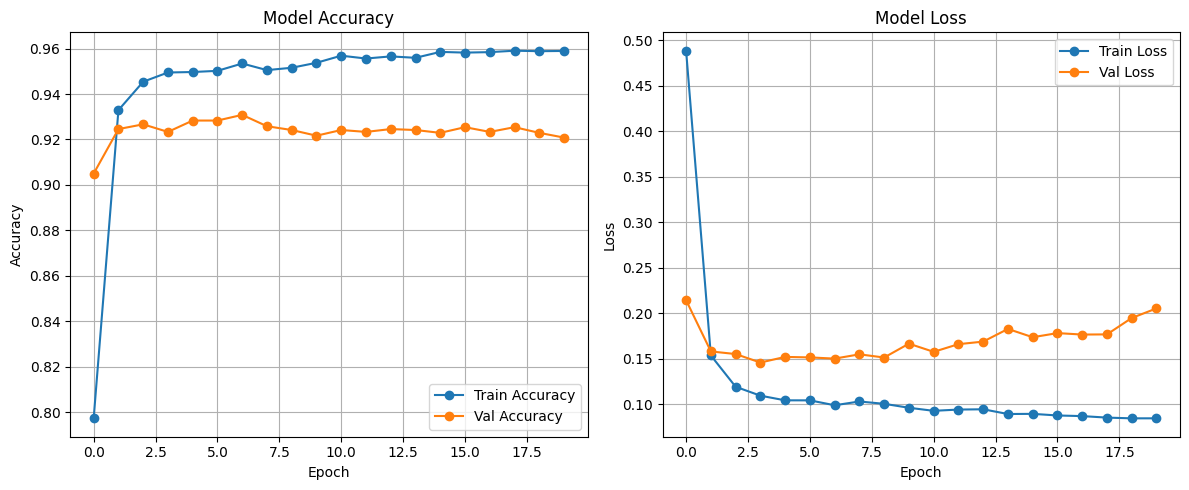

In [ ]:
import matplotlib.pyplot as plt

# ---------------------------
# Plot training & validation accuracy
# ---------------------------
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate on training set
train_loss, train_acc = model.evaluate(X_train_pad, y_train_categorical, verbose=0)
print("Training Accuracy:", round(train_acc*100, 2), "%")

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_pad, y_test_categorical, verbose=0)
print("Testing Accuracy:", round(test_acc*100, 2), "%")


Training Accuracy: 96.41 %
Testing Accuracy: 92.08 %


In [ ]:
# Random Bangla comment
comment = "ক্যামেরার কোয়ালিটি অসাধারণ, ছবি খুব ক্লিয়া্র।"
# Tokenize & pad
seq = tokenizer.texts_to_sequences([comment])
seq_pad = pad_sequences(seq, maxlen=max_seq_len, padding='post', truncating='post')

# Predict
pred = model.predict(seq_pad)

# Get label
label_index = pred.argmax(axis=1)[0]
label = label_encoder.inverse_transform([label_index])[0]

print("Comment:", comment)
print("Predicted Sentiment:", label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Comment: ক্যামেরার কোয়ালিটি অসাধারণ, ছবি খুব ক্লিয়া্র।
Predicted Sentiment: Positive
